In [1]:
%%capture
!pip install transformers datasets tabulate

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from datasets import load_dataset
from tabulate import tabulate

from tqdm.notebook import tqdm
from transformers import BertTokenizer

The goal of this notebook is to implement the model proposed by  Yoon Kim, published in 2014. The original paper can be found [here](https://www.aclweb.org/anthology/D14-1181).
Of course, there exists pytorch and tensorflow implementations on the web. They are more or less correct and efficient. However, here it is important to do it yourself. The goal is to better understand pytorch and the convolution.

The road-map is to:
- Implement the convolution and pooling
- Add dropout on the last layer

To start, it is useful to discover the convolution layers. In this lab, we consider the convolution operation in 1-dimension, followed by the adapted max pooling.


We use the same dataset as before: imdb. The first following cells are very similar to what we did in the HW 1, except that we pool the dataset from the HugginFace hub, using the special `load_dataset` function.


# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In the next cells we are going to experiment with this object.

In [5]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

# Print some keys from the vocabulary
print("Some keys from the vocabulary:", list(tokenizer.vocab.keys())[9000:9010])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
Some keys from the vocabulary: ['screenplay', '##bird', 'contribute', 'indonesian', 'pet', 'creates', '##com', 'enzyme', 'kylie', 'discipline']


In [6]:
def print_sentence(sent):
    """Displays the tokens and respective IDs of a text sample"""
    table = np.array(
        [
            tokenizer.tokenize(sent),
            tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)),
        ]
    ).T
    print(tabulate(table, headers=["Tokens", "Token IDs"], tablefmt="fancy_grid"))


sample = dataset[19]
print_sentence(sample["review"])
print("The label:", sample["sentiment"])

╒═════════════╤═════════════╕
│ Tokens      │   Token IDs │
╞═════════════╪═════════════╡
│ an          │        2019 │
├─────────────┼─────────────┤
│ awful       │        9643 │
├─────────────┼─────────────┤
│ film        │        2143 │
├─────────────┼─────────────┤
│ !           │         999 │
├─────────────┼─────────────┤
│ it          │        2009 │
├─────────────┼─────────────┤
│ must        │        2442 │
├─────────────┼─────────────┤
│ have        │        2031 │
├─────────────┼─────────────┤
│ been        │        2042 │
├─────────────┼─────────────┤
│ up          │        2039 │
├─────────────┼─────────────┤
│ against     │        2114 │
├─────────────┼─────────────┤
│ some        │        2070 │
├─────────────┼─────────────┤
│ real        │        2613 │
├─────────────┼─────────────┤
│ stink       │       27136 │
├─────────────┼─────────────┤
│ ##ers       │        2545 │
├─────────────┼─────────────┤
│ to          │        2000 │
├─────────────┼─────────────┤
│ be      

In [7]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [8]:
preprocessing_fn(dataset[0], tokenizer)

{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

Now we can really prepare the data for the NNet.

🚧 **Data loading** 🚧

Read carefully the data loading process. We want to:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.

Everything is implemented using the `Dataset` class from HuggingFace. It is very convenient and efficient. It is important to understand how it works.

In [9]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))
test_data = dataset.select(range(n_samples, n_samples + 1000))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer})


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])
test_data = test_data.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The dataset now outputs list of ids. However, there is one last remaining step. Since we want to have batch of tensors, they should have the same size.

Below is a code for padding batch of lists to the same size.

> 💡 *Note*: This process can be done a bit quicker with HuggingFace built-in `DataCollator` object, that tokenize + pad at once. But since these objects can be a bit complex at first sight, we present here a custom equivalent method. Moreover, they use the same underlying processes than what we present here.

In [10]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

Let's define the `DataLoaders`.

In [11]:
data_collator = DataCollator(tokenizer)

In [12]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_data, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)
n_test = len(test_data)

In [13]:
print(n_valid)
print(n_train)
print(n_test)

1000
4000
1000


In [14]:
batch = next(iter(train_dataloader))
print("batch is a dictionnary with keys:", batch.keys())
print("Size of different elements:", batch["review_ids"].shape, batch["label"].shape)

batch is a dictionnary with keys: dict_keys(['review_ids', 'label'])
Size of different elements: torch.Size([32, 256]) torch.Size([32, 1])


#Lets code our Convolutionnal classifier

Before that, we have to write a function that allow to retrieve the embedding wheight, and define what model we are are retrieving

In [15]:
def load_model(path, vocab_size, embed_dim):
  model = torch.load(path)
  word_embeddings = model.word_embedding.weight.data
  context_embeddings = model.context_embedding.weight.data
  embeddings = {
      "word" : word_embeddings,
      "context" : context_embeddings
  }
  return embeddings

class Word2Vec(nn.Module):
  def __init__(self, vocab_size : int, embedding_dim : int):
    super().__init__()
    self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
    self.context_embedding = nn.Embedding(vocab_size, embedding_dim)
    self.sigmoid = nn.Sigmoid()
  def forward(self, input_word, input_context):
    word_embedding = self.word_embedding(input_word)
    context_embedding = self.context_embedding(input_context)
    return self.sigmoid(torch.bmm(context_embedding, word_embedding.unsqueeze(2)).squeeze())


In [16]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3, path = None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        if path is not None :
          embeddings = load_model(path, vocab_size, embedding_dim)
          self.embeddings.weight.data = embeddings["context"]
          self.embeddings.weight.requires_grad = False

        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):

        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)

        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

Test the classifier on a random sequence.

In [17]:
path_50 = "/content/model_dim-_50__radius-_5__ratio-_5_-batch_256_-epoch_50_.ckpt"
path_100 = "/content/model_dim-_100__radius-_5__ratio-_5_-batch_256_-epoch_50_.ckpt"
path = path_50
path_k_10 = "/content/model_dim-_100__radius-_5__ratio-_10_-batch_256_-epoch_50_.ckpt"
path_R_10 = "/content/model_dim-_100__radius-_10__ratio-_5_-batch_256_-epoch_50_.ckpt"

In [18]:
model = Conv1dClassifier(vocab_size=VOCSIZE, embedding_dim=50, feature_size=100)
print(model)

Conv1dClassifier(
  (embeddings): Embedding(30522, 50)
  (conv): Conv1d(50, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): AdaptiveMaxPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (out_activation): Sigmoid()
)


# Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent.
- we pick one training example
- compute the loss
- back-propagation of the gradient
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step.

In [19]:
# We redefine the DataLoader, in case you have modified it.
batch_size = 256
train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25 Train Loss: 0.72 Train Acc: 51.33%  | Valid Loss: 0.68 Valid Acc: 57.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25 Train Loss: 0.69 Train Acc: 55.60%  | Valid Loss: 0.67 Valid Acc: 58.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25 Train Loss: 0.67 Train Acc: 59.38%  | Valid Loss: 0.65 Valid Acc: 66.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25 Train Loss: 0.65 Train Acc: 62.10%  | Valid Loss: 0.64 Valid Acc: 68.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25 Train Loss: 0.63 Train Acc: 64.42%  | Valid Loss: 0.63 Valid Acc: 70.80%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25 Train Loss: 0.62 Train Acc: 66.67%  | Valid Loss: 0.61 Valid Acc: 74.40%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25 Train Loss: 0.59 Train Acc: 69.12%  | Valid Loss: 0.59 Valid Acc: 75.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25 Train Loss: 0.56 Train Acc: 72.83%  | Valid Loss: 0.58 Valid Acc: 76.30%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25 Train Loss: 0.54 Train Acc: 74.47%  | Valid Loss: 0.56 Valid Acc: 77.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25 Train Loss: 0.52 Train Acc: 75.12%  | Valid Loss: 0.55 Valid Acc: 76.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25 Train Loss: 0.52 Train Acc: 74.95%  | Valid Loss: 0.54 Valid Acc: 77.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25 Train Loss: 0.50 Train Acc: 76.88%  | Valid Loss: 0.53 Valid Acc: 77.30%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25 Train Loss: 0.48 Train Acc: 78.95%  | Valid Loss: 0.52 Valid Acc: 78.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25 Train Loss: 0.47 Train Acc: 79.10%  | Valid Loss: 0.51 Valid Acc: 78.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25 Train Loss: 0.46 Train Acc: 79.30%  | Valid Loss: 0.50 Valid Acc: 78.20%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25 Train Loss: 0.44 Train Acc: 79.92%  | Valid Loss: 0.50 Valid Acc: 78.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25 Train Loss: 0.42 Train Acc: 81.47%  | Valid Loss: 0.49 Valid Acc: 77.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25 Train Loss: 0.43 Train Acc: 80.92%  | Valid Loss: 0.49 Valid Acc: 77.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25 Train Loss: 0.41 Train Acc: 81.88%  | Valid Loss: 0.48 Valid Acc: 78.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25 Train Loss: 0.42 Train Acc: 81.30%  | Valid Loss: 0.48 Valid Acc: 78.30%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25 Train Loss: 0.39 Train Acc: 82.95%  | Valid Loss: 0.47 Valid Acc: 78.30%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25 Train Loss: 0.38 Train Acc: 84.67%  | Valid Loss: 0.47 Valid Acc: 77.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25 Train Loss: 0.38 Train Acc: 83.95%  | Valid Loss: 0.47 Valid Acc: 78.20%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25 Train Loss: 0.37 Train Acc: 84.08%  | Valid Loss: 0.46 Valid Acc: 78.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25 Train Loss: 0.36 Train Acc: 84.95%  | Valid Loss: 0.46 Valid Acc: 78.80%


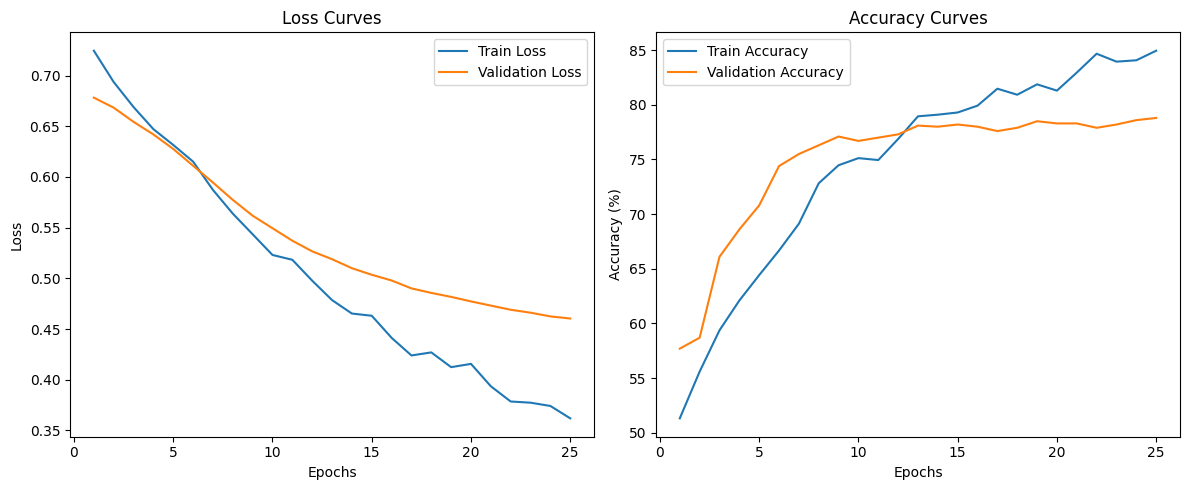

In [21]:
import matplotlib.pyplot as plt

model_50_without_embeddings = Conv1dClassifier(vocab_size=VOCSIZE, embedding_dim=100, feature_size=100)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model_50_without_embeddings.parameters(), lr=0.0005)
n_epochs = 25
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

model_50_without_embeddings.cuda()


def compute_accuracy(predictions, labels):
    pred = (predictions > 0.5).int()
    correct = (labels == pred).sum().item()
    return correct


def train_one_epoch(model, dataloader, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.cuda() for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["review_ids"])
        gold = batch["label"]

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


def validate_one_epoch(model, dataloader, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.cuda() for k, v in batch.items()}
            probs = model(batch["review_ids"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold.float())
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


for epoch in range(n_epochs):
    train_avg_loss, train_avg_acc = train_one_epoch(
        model_50_without_embeddings, train_dataloader, optimizer, loss_function
    )
    valid_avg_loss, valid_avg_acc = validate_one_epoch(
        model_50_without_embeddings, valid_dataloader, loss_function
    )

    train_losses.append(train_avg_loss)
    valid_losses.append(valid_avg_loss)
    train_accs.append(train_avg_acc)
    valid_accs.append(valid_avg_acc)

    print(
        f"Epoch {epoch+1}/{n_epochs}",
        f"Train Loss: {train_avg_loss:.2f}",
        f"Train Acc: {train_avg_acc:.2f}%",
        f" | Valid Loss: {valid_avg_loss:.2f}",
        f"Valid Acc: {valid_avg_acc:.2f}%",
    )

# Plotting Loss and Accuracy Curves
epochs_range = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, valid_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-15-9c9fcb05ef6b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/25 Train Loss: 0.72 Train Acc: 49.83%  | Valid Loss: 0.70 Valid Acc: 51.20%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/25 Train Loss: 0.70 Train Acc: 52.10%  | Valid Loss: 0.69 Valid Acc: 53.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/25 Train Loss: 0.69 Train Acc: 54.42%  | Valid Loss: 0.69 Valid Acc: 55.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/25 Train Loss: 0.68 Train Acc: 57.27%  | Valid Loss: 0.69 Valid Acc: 54.80%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/25 Train Loss: 0.67 Train Acc: 57.17%  | Valid Loss: 0.68 Valid Acc: 55.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/25 Train Loss: 0.67 Train Acc: 60.48%  | Valid Loss: 0.68 Valid Acc: 58.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/25 Train Loss: 0.66 Train Acc: 60.77%  | Valid Loss: 0.68 Valid Acc: 59.40%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/25 Train Loss: 0.66 Train Acc: 61.98%  | Valid Loss: 0.68 Valid Acc: 59.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/25 Train Loss: 0.65 Train Acc: 63.15%  | Valid Loss: 0.68 Valid Acc: 59.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/25 Train Loss: 0.64 Train Acc: 65.83%  | Valid Loss: 0.67 Valid Acc: 61.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/25 Train Loss: 0.64 Train Acc: 66.92%  | Valid Loss: 0.67 Valid Acc: 60.20%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/25 Train Loss: 0.63 Train Acc: 68.35%  | Valid Loss: 0.67 Valid Acc: 61.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/25 Train Loss: 0.62 Train Acc: 70.38%  | Valid Loss: 0.67 Valid Acc: 62.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/25 Train Loss: 0.62 Train Acc: 70.00%  | Valid Loss: 0.66 Valid Acc: 62.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/25 Train Loss: 0.61 Train Acc: 70.62%  | Valid Loss: 0.66 Valid Acc: 63.80%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/25 Train Loss: 0.59 Train Acc: 73.22%  | Valid Loss: 0.66 Valid Acc: 64.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/25 Train Loss: 0.58 Train Acc: 75.22%  | Valid Loss: 0.65 Valid Acc: 64.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/25 Train Loss: 0.58 Train Acc: 74.10%  | Valid Loss: 0.65 Valid Acc: 63.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/25 Train Loss: 0.57 Train Acc: 75.35%  | Valid Loss: 0.65 Valid Acc: 63.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/25 Train Loss: 0.56 Train Acc: 76.60%  | Valid Loss: 0.65 Valid Acc: 64.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/25 Train Loss: 0.55 Train Acc: 75.95%  | Valid Loss: 0.64 Valid Acc: 64.50%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/25 Train Loss: 0.54 Train Acc: 77.58%  | Valid Loss: 0.64 Valid Acc: 65.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/25 Train Loss: 0.53 Train Acc: 79.00%  | Valid Loss: 0.64 Valid Acc: 65.10%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/25 Train Loss: 0.52 Train Acc: 79.33%  | Valid Loss: 0.63 Valid Acc: 66.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/25 Train Loss: 0.51 Train Acc: 80.65%  | Valid Loss: 0.63 Valid Acc: 65.20%


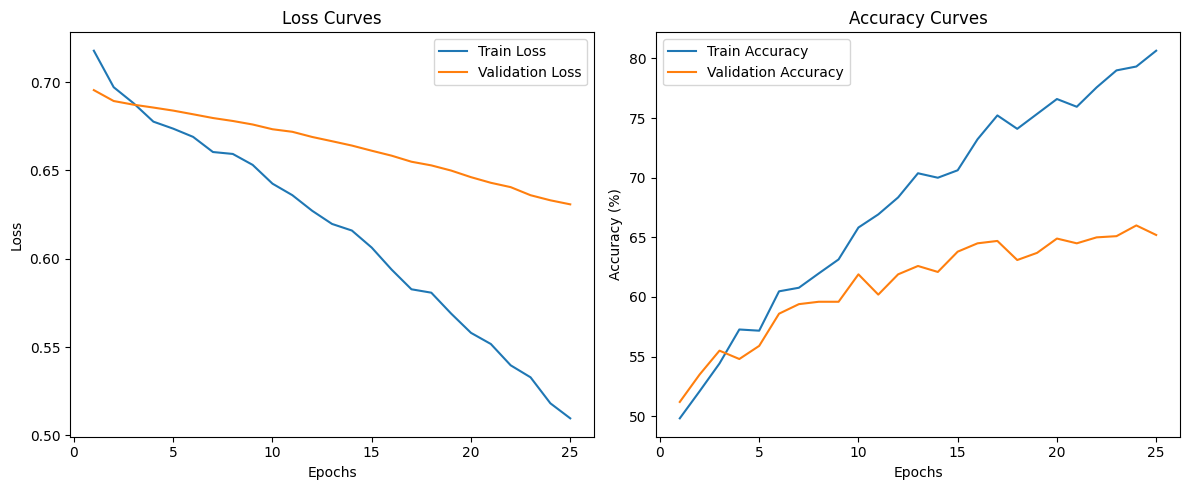

In [22]:
model_100_without_embeddings = Conv1dClassifier(vocab_size=VOCSIZE, embedding_dim=100, feature_size=100, path = path_R_10)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model_100_without_embeddings.parameters(), lr=0.0005)
n_epochs = 25
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

model_100_without_embeddings.cuda()

for epoch in range(n_epochs):
    train_avg_loss, train_avg_acc = train_one_epoch(
        model_100_without_embeddings, train_dataloader, optimizer, loss_function
    )
    valid_avg_loss, valid_avg_acc = validate_one_epoch(
        model_100_without_embeddings, valid_dataloader, loss_function
    )

    train_losses.append(train_avg_loss)
    valid_losses.append(valid_avg_loss)
    train_accs.append(train_avg_acc)
    valid_accs.append(valid_avg_acc)

    print(
        f"Epoch {epoch+1}/{n_epochs}",
        f"Train Loss: {train_avg_loss:.2f}",
        f"Train Acc: {train_avg_acc:.2f}%",
        f" | Valid Loss: {valid_avg_loss:.2f}",
        f"Valid Acc: {valid_avg_acc:.2f}%",
    )

# Plotting Loss and Accuracy Curves
epochs_range = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, valid_losses, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
validate_one_epoch(model_100_without_embeddings,test_dataloader, loss_function )

  0%|          | 0/32 [00:00<?, ?it/s]

(0.6329586021602154, 64.2)